 # Fetching activations from a pretrained model

In [26]:
import os
from functools import partial
from pathlib import Path
from typing import Union

import einops as eo
import git
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from circuitsvis.activations import text_neuron_activations
from circuitsvis.attention import attention_heads
from transformers import AutoModelForCausalLM, AutoTokenizer

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

rc_fonts = {
    "text.usetex": True,
    "text.latex.preamble": "\n".join(
        [r"\usepackage{libertine}", r"\usepackage[libertine]{newtxmath}", r"\usepackage{inconsolata}"]
    ),
}
mpl.rcParams.update(rc_fonts)
plt.rcParams.update(rc_fonts)
sns.set_theme(style="white")

 ### Functions for loading model and fetching activations

In [3]:
def load_model_tokenizer(model_name: str):
    """Load a pretrained model and tokenizer from huggingface.

    Args:
        model_name: The name of the pretrained model to load.

    Returns:
        model: The loaded model.
        tokenizer: The loaded tokenizer.
    """
    model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    tokenizer.pad_token = tokenizer.eos_token
    model.eval()
    return model, tokenizer

In [4]:
def seqlogprob(input_ids, outputs, batch_size, pad_token_id):
    logits = outputs.logits[..., :-1, :].contiguous()
    labels = input_ids[..., 1:].contiguous()

    # compute log probabilities
    log_probs = torch.nn.functional.log_softmax(logits, dim=-1)

    # get per-token probability
    token_log_probs = torch.gather(log_probs, 2, labels.unsqueeze(-1)).squeeze(-1)

    if batch_size > 1:
        # mask padding tokens
        token_log_probs.masked_fill_(labels == pad_token_id, 0.0)

    # sum log probabilities
    return token_log_probs.sum(dim=1)

In [5]:
def compare_blimp(scores):
    first = scores[::2]
    second = scores[1::2]
    # Compare pairs
    return first >= second

In [6]:
def fetch_activations(model, tokenizer, text: Union[list[str], str], layers: list, neurons: list):
    if isinstance(text, str):
        # Batch size of 1
        text = [text]

    # Tokenize the input text with padding to the longest sequence in the batch
    tokenized = tokenizer(text, padding=True, return_tensors="pt", return_offsets_mapping=True)
    # Get the individual tokens from the offsets
    tokens = [
        [text[sample_idx][i:j] for i, j in offsets]
        for sample_idx, offsets in enumerate(tokenized["offset_mapping"])
    ]

    # setup hooks
    save_ctx = {}

    def _save_output_hook(self, inputs, output, layer_num, neurons):
        save_ctx[layer_num] = output[0][
            :, :, neurons
        ].detach()  # gpt2 block output is a tuple where the 0th element is the residual stream

    handles = []
    for layer_idx in layers:
        handles.append(
            model.pico_decoder.layers[layer_idx].register_forward_hook(
                partial(_save_output_hook, layer_num=layer_idx, neurons=neurons)
            )
        )
    # Run through model
    with torch.inference_mode():
        outputs = model(input_ids=tokenized["input_ids"], attention_mask=tokenized["attention_mask"])

    # Remove hook handles from model
    for handle in handles:
        handle.remove()

    seqprob = seqlogprob(tokenized["input_ids"], outputs, len(text), tokenizer.pad_token_id)

    # Stack the activations from all layers
    activations = torch.stack(
        [save_ctx[layer_idx] for layer_idx in layers], dim=2
    )  # (batch_size, padded_seq_length, n_layers, n_neurons)

    # Remove the padding tokens and their corresponding activations
    activations_list = []
    tokens_list = []
    for sample_idx, token in enumerate(tokens):
        num_tokens = tokenized["attention_mask"][sample_idx].sum().item()

        activations_list.append(activations[sample_idx, :num_tokens].numpy())
        tokens_list.append(token[:num_tokens])
    return tokens_list, activations_list, seqprob

In [17]:
def fetch_attention_scores(model, tokenizer, text: Union[list[str], str], layers: list):
    """
    Remember that Q is for the destination tokens, and K is for the source tokens.
        -> Attention moves information from previous (source) tokens, to the current (destination) token.

    For each attention score, the ROW_IDX = DESTINATION (current token)
    """
    if isinstance(text, str):
        # Batch size of 1
        text = [text]

    # Tokenize the input text with padding to the longest sequence in the batch
    tokenized = tokenizer(text, padding=True, return_tensors="pt", return_offsets_mapping=True)

    # Get the individual tokens from the offsets
    tokens = [
        [text[sample_idx][i:j] for i, j in offsets]
        for sample_idx, offsets in enumerate(tokenized["offset_mapping"])
    ]

    # setup hooks
    save_ctx = {}

    def save_attention_hook(self, inputs, output, layer_num):
        input = inputs[0]

        bsz, seq_len, _ = input.shape

        # Unpack inputs and get query and key states
        _queries, _keys = self.q_proj(input), self.k_proj(input)

        # reshape for multihead attn
        queries = _queries.view(bsz, seq_len, self.n_heads, self.head_dim)
        keys = _keys.view(bsz, seq_len, self.n_kv_heads, self.head_dim)

        queries, keys = self.rope(queries, keys, 0)

        # now becomes [bsz, self.n_heads, seq_len, self.head_dim]
        queries = queries.transpose(1, 2)
        keys = keys.transpose(1, 2)

        apply_gqa = self.n_rep > 1
        if apply_gqa:
            keys = keys.repeat_interleave(self.n_rep, dim=-3)

        # Calculate attention scores: [batch_size, n_heads, seq_len, seq_len]
        attention_scores = torch.matmul(queries, keys.transpose(-1, -2))

        # Scale attention scores
        attention_scores = attention_scores / np.sqrt(self.head_dim)

        # Apply attention mask if needed
        attention_mask = tokenized.get("attention_mask", None)

        if attention_mask is not None:
            # Create a mask in the correct shape for broadcasting
            # attention_mask: [batch_size, seq_len] → [batch_size, 1, seq_len, seq_len] lower triangle only
            new_mask = []
            for row in attention_mask:
                num_els = torch.sum(row)
                tot_els = len(row)
                pad = tot_els - num_els
                row_mask = torch.tril(torch.ones(num_els, num_els))
                if pad > 0:
                    row_mask = F.pad(row_mask, (0, pad, 0, pad))

                new_mask.append(row_mask)

            mask = torch.stack(new_mask).unsqueeze(1)

            attention_scores = attention_scores.masked_fill(mask == 0, float("-inf"))

        attention_scores = torch.softmax(attention_scores, dim=-1)

        # Store the attention scores (without softmax)
        save_ctx[layer_num] = attention_scores.detach()

    # Register hooks
    handles = []
    for layer_idx in layers:
        handles.append(
            model.pico_decoder.layers[layer_idx].attention.register_forward_hook(
                partial(save_attention_hook, layer_num=layer_idx)
            )
        )

    # Run through model
    with torch.inference_mode():
        outputs = model(input_ids=tokenized["input_ids"], attention_mask=tokenized["attention_mask"])

    # Remove hook handles from model
    for handle in handles:
        handle.remove()

    seqprob = seqlogprob(tokenized["input_ids"], outputs, len(text), tokenizer.pad_token_id)

    attention_scores_list = []
    tokens_list = []

    for sample_idx, token in enumerate(tokens):
        num_tokens = tokenized["attention_mask"][sample_idx].sum().item()

        # Collect attention patterns for this sample
        sample_scores = []
        for layer_idx in layers:
            # Extract attention pattern for this sample, focusing on real tokens only
            pattern = save_ctx[layer_idx][sample_idx, :, :num_tokens, :num_tokens]
            sample_scores.append(pattern)

        stacked_patterns = torch.stack(sample_scores, dim=0).numpy()

        attention_scores_list.append(stacked_patterns)
        tokens_list.append(token[:num_tokens])

    return tokens_list, attention_scores_list, seqprob

In [ ]:
def fetch_value_weighted_attn_scores(model, tokenizer, text: Union[list[str], str], layers: list):
    """
    Remember that Q is for the destination tokens, and K is for the source tokens.
        -> Attention moves information from previous (source) tokens, to the current (destination) token.

    For each attention score, the ROW_IDX = DESTINATION (current token)
    """
    if isinstance(text, str):
        # Batch size of 1
        text = [text]

    # Tokenize the input text with padding to the longest sequence in the batch
    tokenized = tokenizer(text, padding=True, return_tensors="pt", return_offsets_mapping=True)

    # Get the individual tokens from the offsets
    tokens = [
        [text[sample_idx][i:j] for i, j in offsets]
        for sample_idx, offsets in enumerate(tokenized["offset_mapping"])
    ]

    # setup hooks
    save_ctx = {}

    def save_attention_hook(self, inputs, output, layer_num):
        input = inputs[0]

        bsz, seq_len, _ = input.shape

        # Unpack inputs and get query and key states
        _queries, _keys, _values = self.q_proj(input), self.k_proj(input), self.v_proj(input)

        # reshape for multihead attn
        queries = _queries.view(bsz, seq_len, self.n_heads, self.head_dim)
        keys = _keys.view(bsz, seq_len, self.n_kv_heads, self.head_dim)
        values = _values.view(bsz, seq_len, self.n_kv_heads, self.head_dim)

        queries, keys = self.rope(queries, keys, 0)

        # now becomes [bsz, self.n_heads, seq_len, self.head_dim]
        queries = queries.transpose(1, 2)
        keys = keys.transpose(1, 2)

        apply_gqa = self.n_rep > 1
        if apply_gqa:
            keys = keys.repeat_interleave(self.n_rep, dim=-3)

        # Calculate attention scores: [batch_size, n_heads, seq_len, seq_len]
        attention_scores = torch.matmul(queries, keys.transpose(-1, -2))

        # Scale attention scores
        attention_scores = attention_scores / np.sqrt(self.head_dim)

        # Apply attention mask if needed
        attention_mask = tokenized.get("attention_mask", None)

        if attention_mask is not None:
            # Create a mask in the correct shape for broadcasting
            # attention_mask: [batch_size, seq_len] → [batch_size, 1, 1, seq_len]
            mask = attention_mask[:, None, None, :]
            attention_scores = attention_scores.masked_fill(mask == 0, float("-inf"))

        attention_scores = torch.softmax(attention_scores, dim=-1)

        # Store the attention scores (without softmax)
        save_ctx[layer_num] = attention_scores.detach()

    # Register hooks
    handles = []
    for layer_idx in layers:
        handles.append(
            model.pico_decoder.layers[layer_idx].attention.register_forward_hook(
                partial(save_attention_hook, layer_num=layer_idx)
            )
        )

    # Run through model
    with torch.inference_mode():
        outputs = model(input_ids=tokenized["input_ids"], attention_mask=tokenized["attention_mask"])

    # Remove hook handles from model
    for handle in handles:
        handle.remove()

    seqprob = seqlogprob(tokenized["input_ids"], outputs, len(text), tokenizer.pad_token_id)

    attention_scores_list = []
    tokens_list = []

    for sample_idx, token in enumerate(tokens):
        num_tokens = tokenized["attention_mask"][sample_idx].sum().item()

        # Collect attention patterns for this sample
        sample_scores = []
        for layer_idx in layers:
            # Extract attention pattern for this sample, focusing on real tokens only
            pattern = save_ctx[layer_idx][sample_idx, :, :num_tokens, :num_tokens]
            sample_scores.append(pattern)

        stacked_patterns = torch.stack(sample_scores, dim=0).numpy()

        attention_scores_list.append(stacked_patterns)
        tokens_list.append(token[:num_tokens])

    return tokens_list, attention_scores_list, seqprob

In [8]:
repo_url = "https://huggingface.co/yuvalw/pico-relora-tiny-v2-sn"
commit_hash = "f567508a0d79eb738a23a117a6753650a9969405"  # replace with your desired commit
clone_dir = Path("../runs/rem-relora-tiny-20k")  # the local directory where the repo will be cloned

if not clone_dir.exists():
    repo = git.Repo.clone_from(repo_url, clone_dir)
else:
    repo = git.Repo(clone_dir)

repo.git.checkout(commit_hash)

''

In [9]:
model, tokenizer = load_model_tokenizer(clone_dir)

[2025-05-20 15:22:57,148] [INFO] [real_accelerator.py:222:get_accelerator] Setting ds_accelerator to mps (auto detect)


W0520 15:22:57.371000 98566 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


In [35]:
# text_batch = [
#     "There was a documentary about music irritating Allison.",
#     "There was each documentary about music irritating Allison.",
#     "There are some eggplants disgusting Meredith.",
#     "There are all eggplants disgusting Meredith.",
#     "There was a book scaring Kimberley.",
#     "There was each book scaring Kimberley.",
# ]
text_batch = [
    "Only Bill would ever complain.",
    "Even Bill would ever complain.",
    "Only Grace ever reveals Janice.",
    "Even Grace ever reveals Janice.",
]

In [46]:
layers = list(range(12))
neurons = list(range(96))
tokens, acts, blimp_scores = fetch_activations(model, tokenizer, text_batch, layers, neurons)

In [48]:
all_layers = {}

for act in acts:
    max_indices = np.argmax(act, axis=0)

    # Create a mask where the max index is 2 (third position)
    mask = max_indices == 0

    # Get the indices where mask is True
    positions = np.where(mask)

    neurons_at_layer = {i: set() for i in range(12)}
    for lay, n in zip(*positions):
        neurons_at_layer[lay].add(int(n))

    for lay in neurons_at_layer:
        if all_layers.get(lay, None) is None:
            all_layers[lay] = neurons_at_layer[lay]
        else:
            all_layers[lay] &= neurons_at_layer[lay]

for lay in all_layers:
    print(lay, sorted(all_layers[lay]))

0 [59, 66]
1 [29, 66]
2 [66]
3 [8, 59]
4 [8]
5 [61]
6 [61, 77]
7 [29]
8 [42]
9 []
10 [8]
11 [8, 29, 60]


In [47]:
# Visualise the activations in the notebook
vis = text_neuron_activations(
    tokens=tokens, activations=acts, first_dimension_labels=layers, second_dimension_labels=neurons
)
vis


# If you wish to view this visualisation in a browser, uncomment the below to save the vis to an html file which you can open in a browser
# vis_path = "./vis.html"
# with open(vis_path, "w") as f:
#     f.write(vis._repr_html_())

In [36]:
# Example usage
tokens, att_patts, blimp_scores = fetch_attention_scores(
    model, tokenizer, text_batch, layers=list(range(12))
)


blimp_scores

tensor([-38.8544, -37.3136, -49.6474, -47.5101])

In [37]:
sent = 0
attn = eo.rearrange(att_patts[sent], "l h dst src -> (l h) dst src")
names = [f"L{l} H{h}" for l in range(12) for h in range(12)]
vis = attention_heads(
    tokens=tokens[sent], attention=attn, max_value=1.0, min_value=0.0, attention_head_names=names
)
# L3H10, L4H0, L5H5, L9H7
vis

In [ ]:
def plot_attention_scores_facetgrid(
    attn_scores: list[np.ndarray],
    tokens: list[np.ndarray],
    sent_idx: int,
    layers: list[int] = None,
    heads: list[int] = None,
    figsize=(20, 16),
    cmap="vlag",
):
    # Get sentence attention scores and tokens
    labels = tokens[sent_idx]
    labels = [rf"{label}" for label in labels]

    # Get attention scores array for the sentence
    sentence_scores = attn_scores[sent_idx]

    # Determine which layers and heads to plot
    if layers is None:
        layers = list(range(sentence_scores.shape[0]))
    if heads is None:
        heads = list(range(sentence_scores.shape[1]))

    # Set up the grid layout
    n_layers = len(layers)
    n_heads = len(heads)

    # Create the figure and GridSpec
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(n_layers, n_heads, figure=fig)

    # Create a colormap
    color_palette = sns.color_palette(cmap, as_cmap=True)

    # Find global min and max for consistent color scaling
    global_max = max(
        [sentence_scores[layer_idx, head_idx].max() for layer_idx in layers for head_idx in heads]
    )

    # Plot each layer-head combination
    for i, layer_idx in enumerate(layers):
        for j, head_idx in enumerate(heads):
            # Get scores for this layer and head
            scores = sentence_scores[layer_idx, head_idx]

            # Create annotations
            annotations = np.empty_like(scores, dtype=object)
            for r in range(scores.shape[0]):
                for c in range(scores.shape[1]):
                    annotations[r, c] = rf"${scores[r, c]:.3f}$"

            # Create mask for upper triangle
            mask = np.triu(np.ones_like(scores, dtype=bool), k=1)

            # Create subplot
            ax = fig.add_subplot(gs[i, j])

            # Plot heatmap
            sns.heatmap(
                scores,
                mask=mask,
                cmap=color_palette,
                center=0,
                square=True,
                linewidths=0.5,
                cbar=j == n_heads - 1,  # Only show colorbar for rightmost plots
                cbar_kws={"shrink": 0.5} if j == n_heads - 1 else None,
                annot=annotations,
                vmin=-global_max,
                vmax=global_max,
                fmt="",
                annot_kws={"usetex": True, "size": 8},
                xticklabels=labels if i == n_layers - 1 else False,  # Only show xlabels for bottom row
                yticklabels=labels if j == 0 else False,  # Only show ylabels for leftmost column
                ax=ax,
            )

            # Add title
            ax.set_title(f"Layer {layer_idx}, Head {head_idx}")

            # Rotate x-axis labels if showing them
            if i == n_layers - 1:
                plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Adjust layout
    plt.tight_layout()
    return fig

In [38]:
# transform att_patts to dataframe
def _get_att_patt_data():
    for sent_idx, att_patt in enumerate(att_patts):
        # remember that rows are the destination index that wants info from other tokens
        # source tokens are being attended to
        for (layer, head, dst_idx, src_idx), score in np.ndenumerate(att_patt):
            if dst_idx >= src_idx:  # lower triangle only
                yield (sent_idx, layer, head, dst_idx, src_idx, score)


att_patt_df = pd.DataFrame(
    _get_att_patt_data(), columns=["SentNum", "Layer", "Head", "Destination Token", "Source Token", "Score"]
)

In [39]:
def filter_df(df: pd.DataFrame, sent_nums: tuple[int], layer: int, head: int):
    mask = (df["Layer"] == layer) & (df["Head"] == head) & df["SentNum"].isin(sent_nums)
    return df[mask]

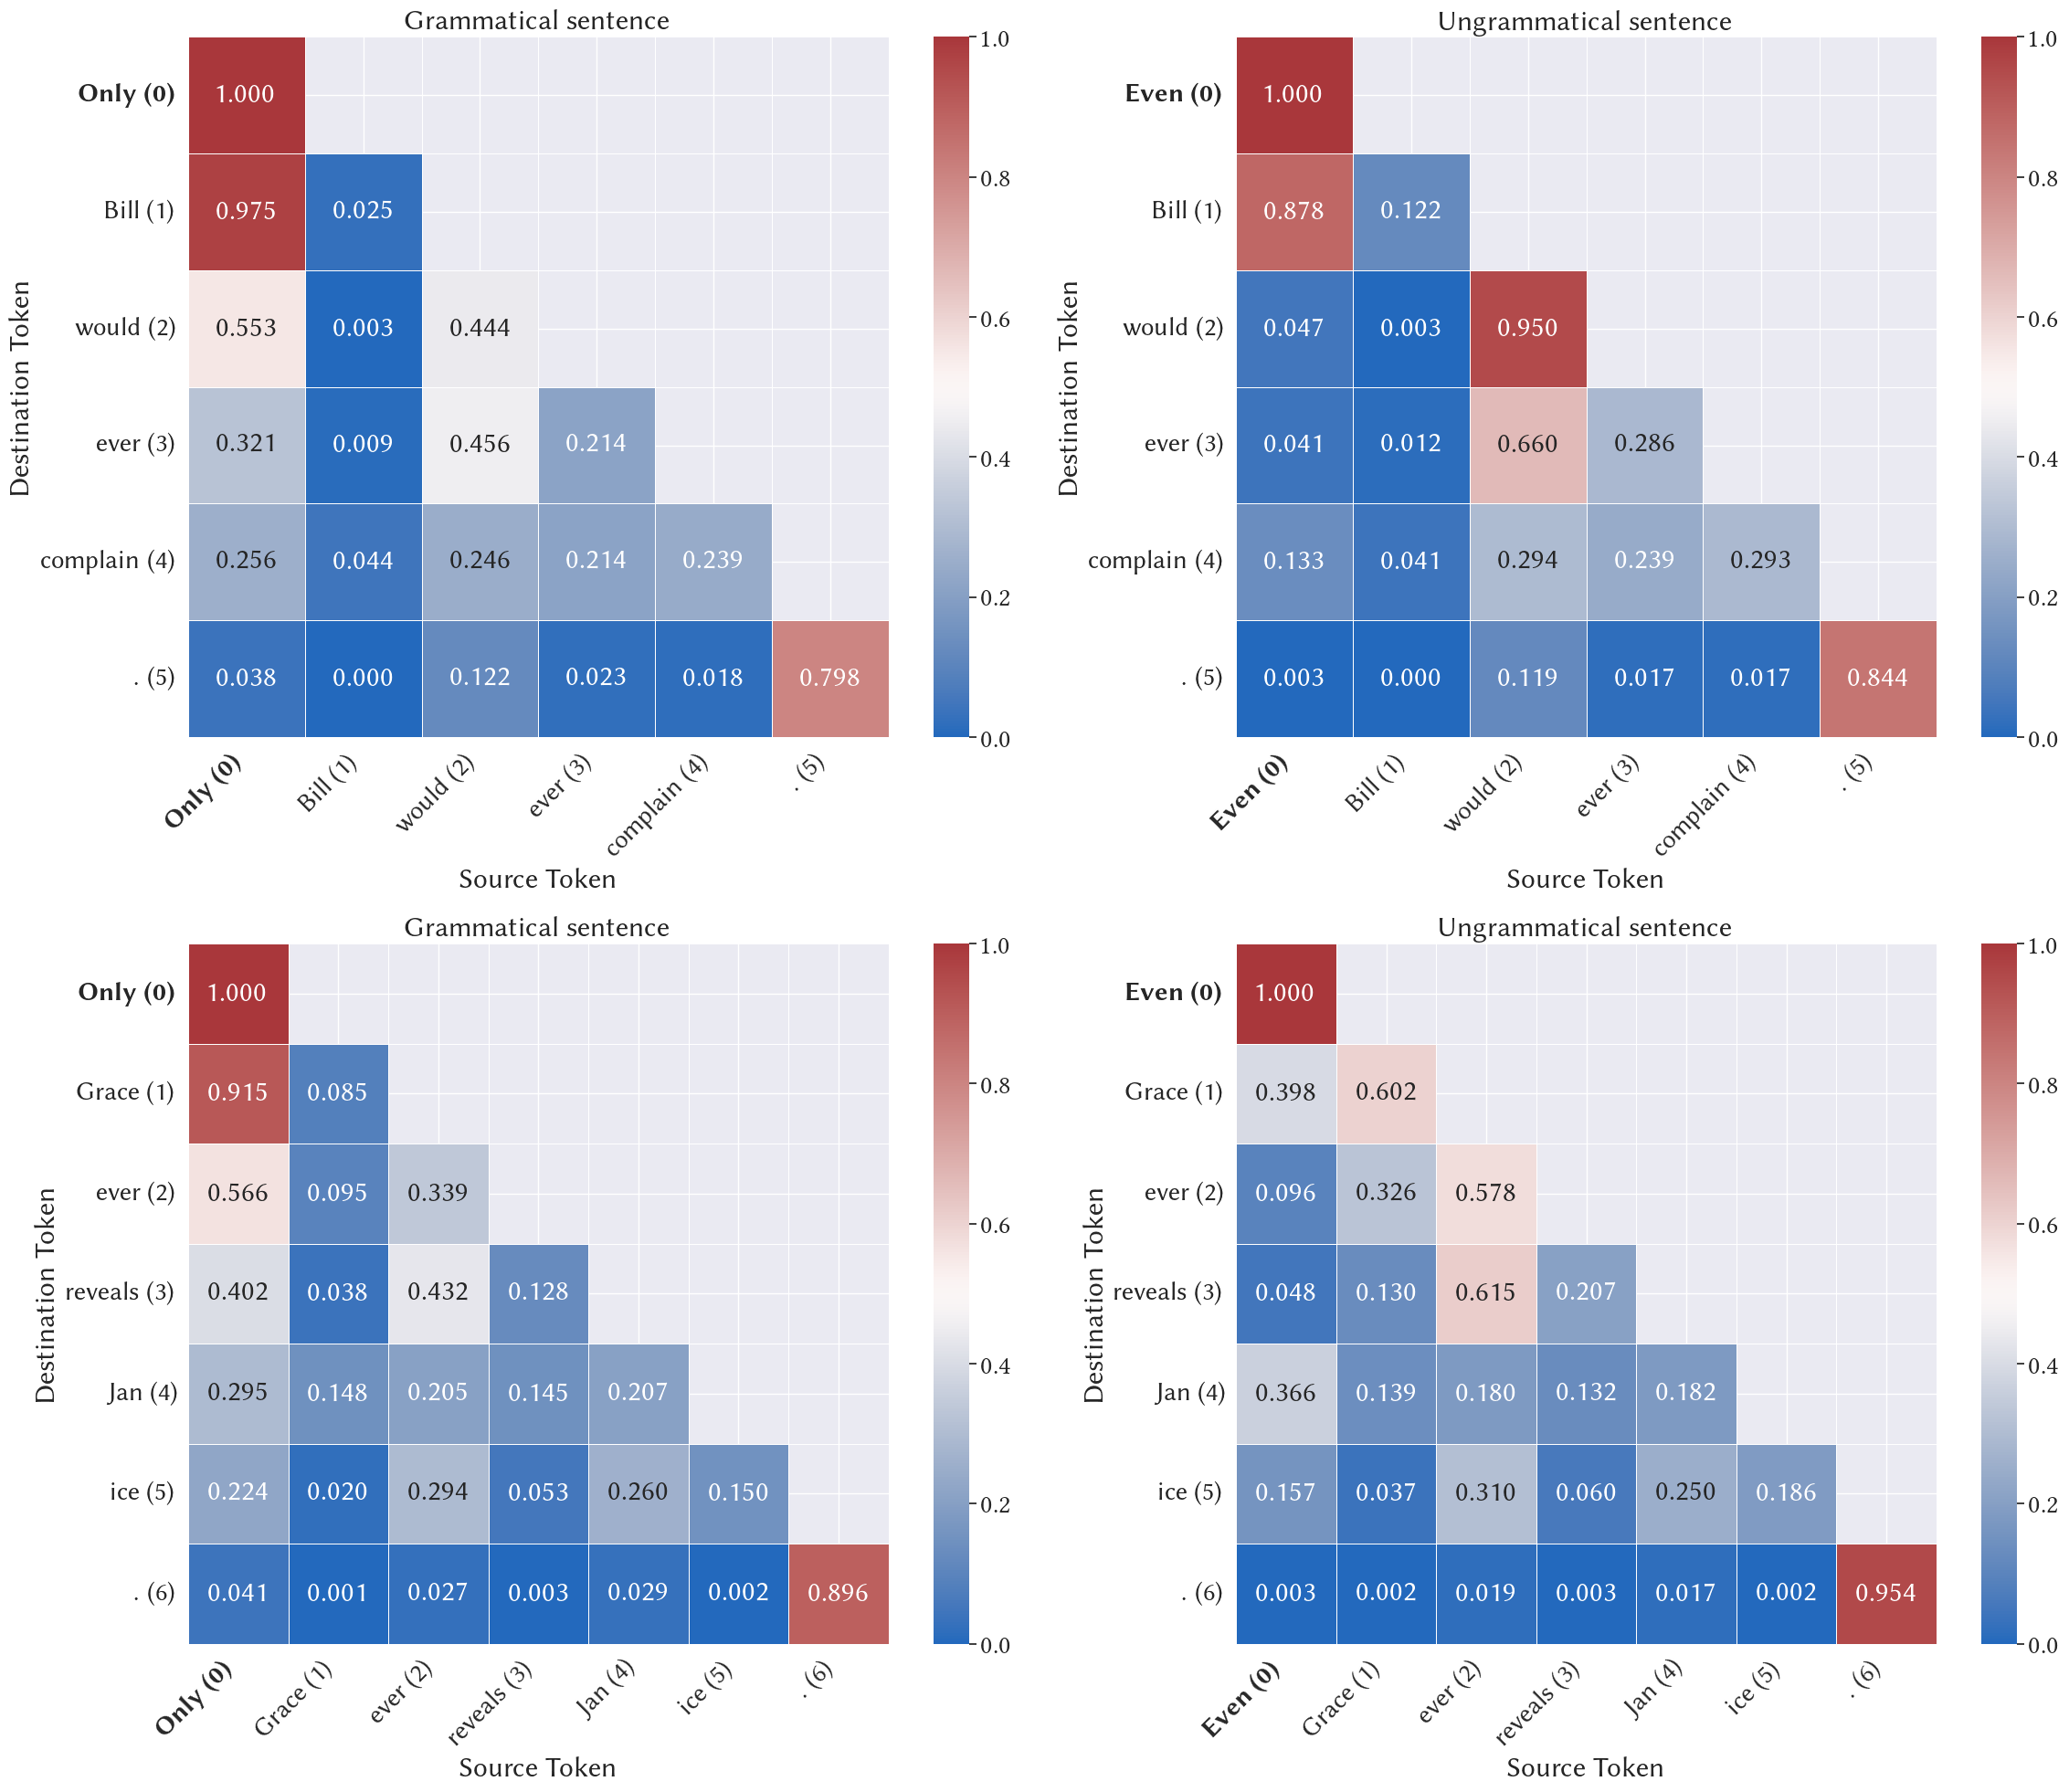

In [56]:
font_scale = 1.9

sns.set_theme(font_scale=font_scale, rc={"axes.grid": "True", "axes.grid.which": "both"})
g = sns.FacetGrid(
    data=filter_df(att_patt_df, (0, 1, 2, 3), layer=4, head=0),
    col="SentNum",
    col_wrap=2,
    height=10,
    aspect=1.2,
    sharey=False,
    sharex=False,
    margin_titles=False,
)


def plot_heatmap(data: pd.DataFrame, **kwargs):
    # Create a pivot table for the heatmap
    sent_num = data["SentNum"].iloc[0]
    pivot_data = data.pivot(index="Destination Token", columns="Source Token", values="Score")
    pivot_data.sort_index(inplace=True)

    key_tokens = kwargs.get("key_tokens", "auto")
    if isinstance(key_tokens, int):
        key_tokens = (key_tokens,)
    elif key_tokens == "auto":
        key_tokens = [
            idx
            for idx, (t1, t2) in enumerate(zip(tokens[sent_num], tokens[sent_num + (-1) ** (sent_num % 2)]))
            if t1 != t2
        ]

    labels = [
        f"{token} ({idx})" if idx not in key_tokens else rf"\textbf{{{token} ({idx})}}"
        for idx, token in enumerate(tokens[sent_num])
    ]

    ax = sns.heatmap(
        pivot_data,
        cmap="vlag",
        center=0.5,
        square=True,
        linewidths=0.5,
        vmin=0,
        vmax=1,
        cbar=kwargs.get("add_cbar", True),
        annot=True,
        xticklabels=labels,
        yticklabels=labels,
        fmt=".3f",
    )

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, va="center")


g.map_dataframe(
    plot_heatmap,
    key_tokens="auto",
)

g.set_titles(col_template="")

for ax, col_val in zip(g.axes.flat, g.col_names):
    sent_num = int(col_val)
    title = "Grammatical sentence" if sent_num % 2 == 0 else "Ungrammatical sentence"
    ax.set_title(title)


plt.show()